#### Twitter Mining Project
Course: CISD 43 <br>
Professor: Sohair Zaki <br>
Student: Jack Chen <br>
<br>
Purpose:<br>
- Text mining via twitter api, implement natural language processing (NLP), cleaning text data, visualization, Name Entity Recognition<br>
- Implement Deep Learning model, compare with TextBlob
Tasks:<br>
- Pre-Setup
- Twitter API
- Load, Clean, Visualize Numeric Data
- NLP<br>
-- Clean Data<br>
-- Visualize Data<br>
-- Name Entity Recognition
- Deep Learning

<br>
Conclusion:
2022-03-27 Before Will Smith slapped Chris Rock, there was barely any tweets. About 2 hours later after Oscars, the tweets started exploding. Tweets lasted about 1 week and starts falling off. 2022-04-08 Announcement of Will get banned for 10 years, the tweets started exploding again. After about 1 weeks, they tweets started falling off again.

- In order to promote on tweets, seems like only 1 week the trend/hype will scale off. So best to act within 1 week.

- From previous students' projects, there was minority percent of android users. Mostly iPhone, iPad, or Apple products. Now the tweet source from Androids has almost have same share of iPhone. Website takes 3rd place. The growth of Android is huge.





#### Pre-Setup: Loading Data, Functions, etc

In [52]:
# Importing Libraries
# import webbrowser
# import time
import tweepy
from tweepy import Stream
from tweepy import OAuthHandler
import os
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
# import files into variable
import glob
import nltk
nltk.download('stopwords')
nltk.download('words')
words = set(nltk.corpus.words.words())
from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS
import spacy
from spacy import displacy
from nltk.corpus import stopwords 
import string
# import langid to detect language
import langid
from textblob import TextBlob
import collections
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
import pickle
# load model
lstm = load_model('data3/LSTM.h5') # max length 15

# load tokenizer
with open('data3/token_mdl1.pickle', 'rb') as handle:
    token = pickle.load(handle)



# load keys into keys
#[apiKey,apiKeySecret,bearerTokem,accessToken,accessTokenSecret]
# Consumer Keys: apiKey, apiKeySecret
# Access Keys: accessToken, accessTokenSecret
# for window
# path =  r'C:\Users\Gumo\Desktop\Git\selfBooks\tweepy.txt'
# for mac
path = 'tweepy.txt'
keys = []
with open(path, mode='r') as w:
    for line in w:
        keys.append(line.split(': ')[1].strip())
access_token = keys[3]
access_secret = keys[4]
consumer_key = keys[0]
consumer_secret = keys[1]
bearer_token = keys[2]

###### my id/name #####
myUserId = 1309643764172947456
myUsername = 'stockjanitor'


[nltk_data] Downloading package stopwords to /Users/Gumo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /Users/Gumo/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [53]:
###### FUNCTIONS ######
def tweetPost(text):
    try:
        twitterApi.update_status(text)
        print("bling bling~~")
    except:
        print("boom boom")
def tweetMedia(text, img):
    try:
        media = twitterApi.media_upload(img)
        twitterApi.update_status(text,media_ids=[media.media_id_string])
        print("bling bling~~")
    except:
        print("boom boom")
def tweetFriend(name):
    try:
        twitterApi.create_friendship(screen_name=name)
        print("bling bling~~")
    except:
        print("boom boom")
def tweetUnfriend(name):
    try:
        twitterApi.destroy_friendship(screen_name=name)
        print("bling bling~~")
    except:
        print("boom boom")

# Regex Remove functions
# remove url
def remove_url(txt):
    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())
#remove hashtag #
def remove_hashtag(txt):
    return " ".join(re.sub("([#＃]+)([0-9A-Z_]*[A-Z_]+[a-z0-9_üÀ-ÖØ-öø-ÿ]*)", "", txt).split())
# remove mention @
def remove_at(txt):
    return " ".join(re.sub("(\@[a-zA-Z0-9_%]*)", "", txt).split())

    # remove stopwords and puncturations
def get_text_processing(text):
    stpword = stopwords.words('english')
    stpword.remove('not')
    no_punctuation = [char for char in text if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stpword])

# remove url, hashtag, at, stop words, punctuation
def remove3(a):
    x = remove_at(a)
    x = remove_hashtag(x)
    x = remove_url(x)
    x = get_text_processing(x.lower())
    return x

# found empty text rows, remove them by replacing with none
def fillNa(x):
    if x == '':
        return 'none'

# detect language - Note: may not be most accurate
def lanDetectFunc(x):
    a = langid.classify(x)
    return a[0]

# convert to english only words
def engOnly(x):
    a = " ".join(w for w in nltk.wordpunct_tokenize(x) if w.lower() in words ) #or not w.isalpha()
    return a

# determine text sentiment using TextBlob
def blobSent(x):
    a = TextBlob(x)
    if a.sentiment.polarity > 0:
        return 'Positive'
    elif a.sentiment.polarity == 0:
        return 'Neutral'
    else:
        return 'Negative'

# Remove names from text
def removeName(x):
    names = ['will', 'jada', 'smith', 'chris', 'rock']
    new_text = []
    for a in x:
        if a not in names:
            new_text.append(a)
    return new_text

# Predict Sentiment with made model
def predictFunc(x):
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    try:
        # since x is cleaned, we tokenize right away
        a = token.texts_to_sequences(x)

        # apply padding
        a_pad = pad_sequences(a, maxlen = 15, padding='post')

        # predict
        y = lstm.predict(a_pad).argmax(axis=1)
        a = sentiment_classes[y[0]]
    except:
        a = 'NoWork'
    return a

#### Twitter API to pull data

In [54]:
# Twitter API v1 - auth keys (Cursor)
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token,access_secret)

# create instance
twitterApi = tweepy.API(auth, wait_on_rate_limit=True)
# wait on rate limit, not to get errors on timing out

# verify credential
try:
    # see if credential works
    twitterApi.verify_credentials()
    print("twitterApi works")
except:
    print("Please fix me")

# Twitter API v2 - auth keys (Client)
# for user access, tweeting etc
client = tweepy.Client(consumer_key=consumer_key,consumer_secret=consumer_secret,access_token=access_token,access_token_secret=access_secret)

# for query access, search tweets etc
clientBearer = tweepy.Client(bearer_token=bearer_token)

twitterApi works


##### Client - v2

In [55]:
# # store responses of query1 in response1
# response1 = clientBearer.search_all_tweets(query=query1, max_results=10, start_time= "2022-03-28T12:12:01Z", end_time='2022-03-27T13:12:01Z',tweet_fields=['id','text', 'created_at','geo','source', 'public_metrics'])


# # convert response into list1
# list1 = [[tweet.id,tweet.text,tweet.created_at,tweet.geo,tweet.source,tweet.public_metrics]for tweet in response1.data]

# # load to df
# # df = original df 
# df = pd.DataFrame(data=list1,columns=['userid','text','time','location','source','metrics'])

# # show df
# df.head(3)

In [56]:
# # assign new df for editing
# df1 = df

# # extract public metrics into respective columns
# df1['retweet_count'] = df.metrics.apply(lambda x: list(x.items())[0][1])
# df1['reply_count'] = df.metrics.apply(lambda x: list(x.items())[1][1])
# df1['like_count']= df.metrics.apply(lambda x: list(x.items())[2][1])
# df1['quote_count']= df.metrics.apply(lambda x: list(x.items())[3][1])

# # drop the metrics since we have extracted it
# df1 = df1.drop(columns='metrics')

# #show df
# df1.head(3)

##### Cursor v1

In [57]:
# set query1
query1 = "jadasmith"
hour = '08'

date = '20220415'
time =hour+'00'
time2=hour+'59'
fromdate =date+time
todate=date+time2

######################## Search 30 Day Queries ########################
# store search in tweets
queryResponse1 = twitterApi.search_30_day(label='30Days',query=query1,fromDate=fromdate,toDate=todate,maxResults=100)
# save tweets to list1
list1 = [[tweet.user.screen_name,tweet.text,tweet.created_at,tweet.user.location,tweet.source,tweet.favorite_count,tweet.quote_count,tweet.reply_count,tweet.retweet_count]for tweet in queryResponse1]
# convert tweet list into dataframe
df = pd.DataFrame(data=list1,columns=['user','text','time','location','source','like_count','quote_count','reply_count','retweet_count'])
# save to dataframe
df.to_csv('data/'+date+time+time2+query1+'.csv')
df.shape



######################## Search Recent queries ########################
# sincedate=''
# queryResponse1 = twitterApi.search_tweets(q=query1,until=sincedate,count=100)
# # items = 5, retrieve 5 tweets
# list1 = [[tweet.user.screen_name,tweet.text,tweet.created_at,tweet.user.location,tweet.source,tweet.favorite_count,tweet.retweet_count]for tweet in queryResponse1]
# # convert tweet list into dataframe
# df = pd.DataFrame(data=list1,columns=['user','text','time','location','source','like_count','retweet_count'])
# # save to dataframe
# df.to_csv('data/'+sincedate+query1+'.csv')
# df.shape


(0, 9)

#### Load, Clean, and Visualize Numeric Data

##### Clean Data

In [58]:
pathOfData = 'data/' 
# saves path all file name to variable all_files
all_files = glob.glob(os.path.join(pathOfData , "*.csv"))
#initiate a list
merged_list1 = []

# loop all files to append each file to list
for a in all_files:
    df = pd.read_csv(a, index_col=None, header=0)
    merged_list1.append(df)

# concat all files
merged_df1 = pd.concat(merged_list1, axis=0, ignore_index=True)
merged_df1.shape

(5867, 10)

In [59]:
pathOfData = 'data2/' 
# saves path all file name to variable all_files
all_files2 = glob.glob(os.path.join(pathOfData , "*.csv"))
#initiate a list
merged_list2 = []

# loop all files to append each file to list
for b in all_files2:
    df = pd.read_csv(b, index_col=None, header=0)
    merged_list2.append(df)

# concat all files
merged_df2 = pd.concat(merged_list2, axis=0, ignore_index=True)
merged_df2.shape

(297, 8)

In [60]:
merged_df2.head(3)

,Unnamed: 0,user,text,time,location,source,like_count,retweet_count
0,0,larepublica_pe,RT @LRTendencias: 🎬 😕 Primero #Netflix y ahora...,2022-04-22 18:24:18+00:00,"Lima, Perú",Twitter Web App,0,1
1,1,AdetoroMph,#ChrisRock: Where was #WillSmith when #MeekMil...,2022-04-22 18:22:40+00:00,"Princeton, NJ",Twitter for iPhone,0,0
2,2,Melisa_Porte,@chrisrock Who's bored her too?,2022-04-22 18:21:49+00:00,NaN,Twitter Web App,0,0


In [61]:
merged_df1.head(3)

,Unnamed: 0,user,text,time,location,source,like_count,quote_count,reply_count,retweet_count
0,0,damnratez,@KevinHart4real @chrisrock deer infomous https...,2022-04-10 21:57:54+00:00,Sailacross It's Firebizar🙄🎶,Twitter for Android,0,0,0,0
1,1,djBESWOLF,#wolfliveapp #wolflive #wolflovers #music #liv...,2022-04-10 21:57:53+00:00,"London, England",Twitter for iPhone,0,0,0,0
2,2,_Dani_Danis_,RT @hotvickkrishna: The Oscars Meeting about W...,2022-04-10 21:56:46+00:00,Schweiz,Tweetbot for iΟS,0,0,0,0


In [62]:
# add missing columns - due to v1 recent twitter pull missing those data
merged_df2['quote_count'] = 'NaN'
merged_df2['reply_count'] = 'NaN'
merged_df2.head(3)

,Unnamed: 0,user,text,time,location,source,like_count,retweet_count,quote_count,reply_count
0,0,larepublica_pe,RT @LRTendencias: 🎬 😕 Primero #Netflix y ahora...,2022-04-22 18:24:18+00:00,"Lima, Perú",Twitter Web App,0,1,NaN,NaN
1,1,AdetoroMph,#ChrisRock: Where was #WillSmith when #MeekMil...,2022-04-22 18:22:40+00:00,"Princeton, NJ",Twitter for iPhone,0,0,NaN,NaN
2,2,Melisa_Porte,@chrisrock Who's bored her too?,2022-04-22 18:21:49+00:00,NaN,Twitter Web App,0,0,NaN,NaN


In [63]:
# obtain columns names, so we can rearrange it into same column order and append
mdf2col = merged_df2.columns.tolist()
print(mdf2col)

['Unnamed: 0', 'user', 'text', 'time', 'location', 'source', 'like_count', 'retweet_count', 'quote_count', 'reply_count']


In [64]:
# rearrange df1, append, show shape
merged_df1 = merged_df1[['Unnamed: 0', 'user', 'text', 'time', 'location', 'source', 'like_count', 'retweet_count', 'quote_count', 'reply_count']]
master_df = pd.concat([merged_df1,merged_df2])
master_df.shape

(6164, 10)

In [65]:
# drop the named:0 column
master_df=master_df.iloc[:,1:]
# reset index and drop old index
master_df = master_df.reset_index(drop=True)
master_df.shape

(6164, 9)

In [66]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6164 entries, 0 to 6163
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   user           6164 non-null   object
 1   text           6164 non-null   object
 2   time           6164 non-null   object
 3   location       3779 non-null   object
 4   source         6164 non-null   object
 5   like_count     6164 non-null   object
 6   retweet_count  6164 non-null   object
 7   quote_count    6164 non-null   object
 8   reply_count    6164 non-null   object
dtypes: object(9)
memory usage: 433.5+ KB


In [67]:
# function detect bot
def botDetect(x):
    if 'bot' in x:
        return True
# convert to string
master_df['bot'] = master_df['source'].apply(lambda x: botDetect(x.lower()))
master_df.head()

,user,text,time,location,source,like_count,retweet_count,quote_count,reply_count,bot
0,damnratez,@KevinHart4real @chrisrock deer infomous https...,2022-04-10 21:57:54+00:00,Sailacross It's Firebizar🙄🎶,Twitter for Android,0,0,0,0,None
1,djBESWOLF,#wolfliveapp #wolflive #wolflovers #music #liv...,2022-04-10 21:57:53+00:00,"London, England",Twitter for iPhone,0,0,0,0,None
2,_Dani_Danis_,RT @hotvickkrishna: The Oscars Meeting about W...,2022-04-10 21:56:46+00:00,Schweiz,Tweetbot for iΟS,0,0,0,0,True
3,MsAnalytical15,"📣 New Podcast! ""Janet Hubert 'Original Aunt Vi...",2022-04-10 21:56:43+00:00,NaN,Spreaker,1,0,0,0,None
4,okuleygodfryd,"Let's be honest, before @chrisrock got slapped...",2022-04-10 21:56:35+00:00,"Accra, Ghana",Twitter for iPhone,0,0,0,0,None


In [68]:
# count num of bots
master_df.bot.value_counts()

True    31
Name: bot, dtype: int64

In [69]:
# save to df, drop bot, drop bot column, reset index
master_df1 = master_df[master_df['bot'] != True].iloc[:,0:-1].reset_index(drop=True)
master_df1.columns

Index(['user', 'text', 'time', 'location', 'source', 'like_count',
       'retweet_count', 'quote_count', 'reply_count'],
      dtype='object')

In [70]:
master_df1.sort_values(by="retweet_count",ascending=False).head(1)

,user,text,time,location,source,like_count,retweet_count,quote_count,reply_count
5932,76393mk2,RT @PeteFighter: OK……. This one wins!!\n#WillS...,2022-04-22 14:43:47+00:00,SW-8451-6194-1526,Twitter Web App,0,6349,NaN,NaN


In [71]:
# drop duplicate text, reset index
# master_df1.drop_duplicates(subset='text',keep='last',inplace=True)
# master_df1.reset_index(drop=True)
# master_df1.tail()
# master_df1.sort_values(by="retweet_count",ascending=False)


# Notes: cannot drop duplicates because many are retweets, and it will mess up the retweet count, 
# also in the sentiment analysis, more retweets should have more weight

In [72]:
# function detect will
def willDetect(x):
    if 'will' in x:
        a = 1
    else:
        a = 0
    return a
# function detect jada
def jadaDetect(x):
    if 'jada' in x:
        a = 1
    else:
        a = 0
    return a
# function detect chris
def chrisDetect(x):
    if 'chris' in x:
        a = 1
    else:
        a = 0
    return a
# convert to string
master_df1['willsmith'] = master_df1['text'].apply(lambda x: willDetect(x.lower()))
master_df1['chrisrock'] = master_df1['text'].apply(lambda x: chrisDetect(x.lower()))
master_df1['jadasmith'] = master_df1['text'].apply(lambda x: jadaDetect(x.lower()))
# master df1 done ready for next step
# its like cleaned raw df
master_df1.tail(3)

,user,text,time,location,source,like_count,retweet_count,quote_count,reply_count,willsmith,chrisrock,jadasmith
6130,Taurus89514630,RT @mid_day: #ICYMI Top 10 #EntertainmentNews ...,2022-04-22 17:18:03+00:00,NaN,Twitter for Android,0,352,NaN,NaN,1,0,0
6131,LSwagata,RT @mid_day: #ICYMI Top 10 #EntertainmentNews ...,2022-04-22 17:17:25+00:00,NaN,Twitter for Android,0,352,NaN,NaN,1,0,0
6132,ChangeMyJg,RT @GabyMeza8: CONFIRMADO: #Netflix cancela su...,2022-04-22 17:16:55+00:00,México,Twitter for Android,0,39,NaN,NaN,0,0,0


In [73]:
# assign new df
master_df2 = master_df1

# only get dates
def convTime(x):
    x = x[:10]
    return x
    
# df2 has time converted convert time
master_df2['time'] = master_df2['time'].apply(lambda x: convTime(x))


In [74]:
# group by dates, so we can peak at tweet count trend
tweetTrend_df = master_df2[['time','willsmith','chrisrock','jadasmith','like_count','retweet_count']].groupby('time').sum().reset_index()
likeRetweetCount = master_df2[['time','like_count','retweet_count']].groupby('time').sum().reset_index()
# merge them
mergeGroupby_df = tweetTrend_df.merge(likeRetweetCount, how = 'inner', on = 'time')
mergeGroupby_df.sort_values(by='retweet_count',ascending=False).head(3)


,time,willsmith,chrisrock,jadasmith,like_count,retweet_count
15,2022-04-22,116,86,39,78,47638
13,2022-04-20,9,0,10,12,2122
12,2022-04-19,5,2,6,10,1800


In [75]:
master_df2.source.value_counts()

Twitter for iPhone                 2156
Twitter for Android                2122
Twitter Web App                    1450
Twitter for iPad                    125
TweetDeck                            54
                                   ... 
Twitterrific for iOS                  1
Erin Sakura                           1
The Catford Social Network, LDN       1
Twitter DAO                           1
Missinglettr                          1
Name: source, Length: 89, dtype: int64

In [76]:
# converting source to prepare piechart
sourceCount_df = pd.DataFrame(master_df2.source.value_counts()).reset_index()
sourceCount_df.rename(columns={"index": "sourcename"}, inplace=True)

# store sourcename
sourcelist= list(sourceCount_df.sourcename.head(6))

# convert source names
def sourceConv(x):
    if x in sourcelist:
        return str(x)
    else:
        return 'Others'

sourceCount_df["sourcename2"] = sourceCount_df['sourcename'].apply(lambda x: sourceConv(x))

#groupby new srouce name, reset index
sourceCount_df = sourceCount_df.groupby('sourcename2').sum().reset_index()
# calculate percent
sourceCount_df["percent"] = sourceCount_df['source'].apply(lambda x: x/sourceCount_df['source'].sum())
sourceCount_df = sourceCount_df.sort_values(by=['source'])
sourceCount_df


,sourcename2,source,percent
0,Instagram,25,0.004076
2,TweetDeck,54,0.008805
5,Twitter for iPad,125,0.020382
1,Others,201,0.032774
3,Twitter Web App,1450,0.236426
4,Twitter for Android,2122,0.345997
6,Twitter for iPhone,2156,0.351541


##### Visualization

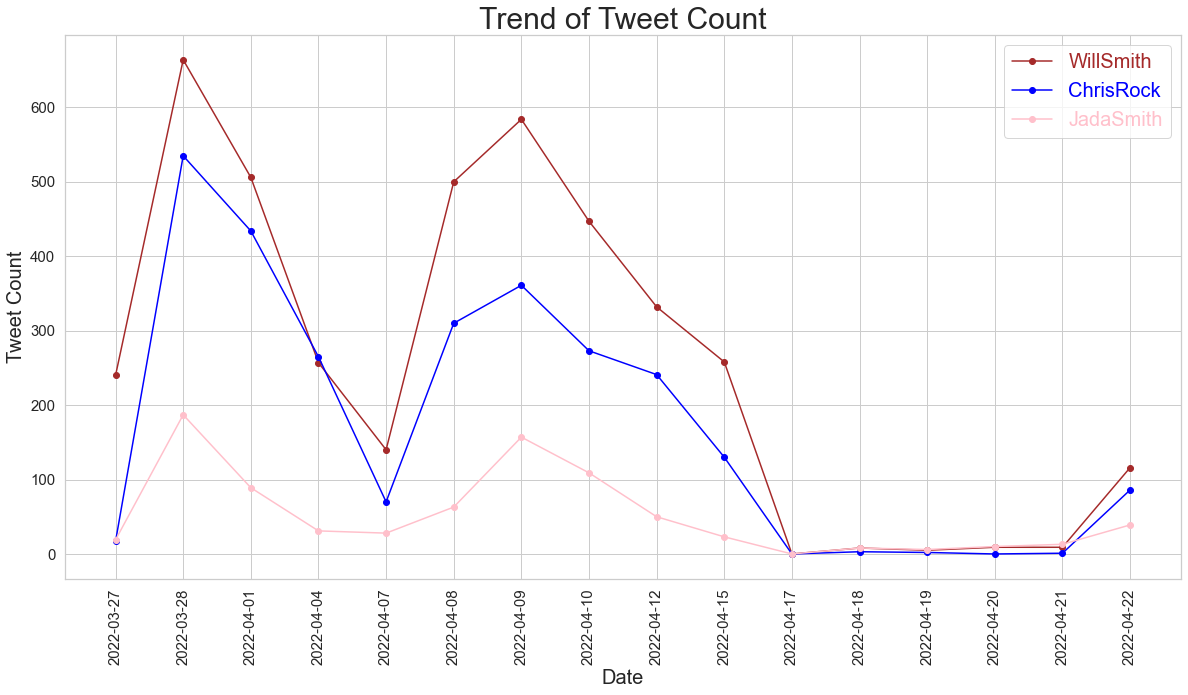

In [77]:
sns.set_theme(style="whitegrid") # all charts will have a light grid
plt.figure(figsize=(20,10))
plt.plot(mergeGroupby_df.time, mergeGroupby_df.willsmith, 'o-', label="WillSmith", color='brown')
plt.plot(mergeGroupby_df.time, mergeGroupby_df.chrisrock, 'o-', label="ChrisRock", color='blue')
plt.plot(mergeGroupby_df.time, mergeGroupby_df.jadasmith, 'o-', label="JadaSmith", color='pink')

plt.xlabel('Date', fontsize=20)
plt.ylabel('Tweet Count', fontsize = 20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15,rotation=90)
plt.title('Trend of Tweet Count', fontsize=30)
plt.legend(labels=['WillSmith','ChrisRock','JadaSmith'],labelcolor=['brown','blue','pink'],loc="upper right", prop={'size': 20})

There are barely tweets about Jada on twitter. The hype seems to fall off within a week of event occurring.

Text(0.5, 1.0, 'Sources')

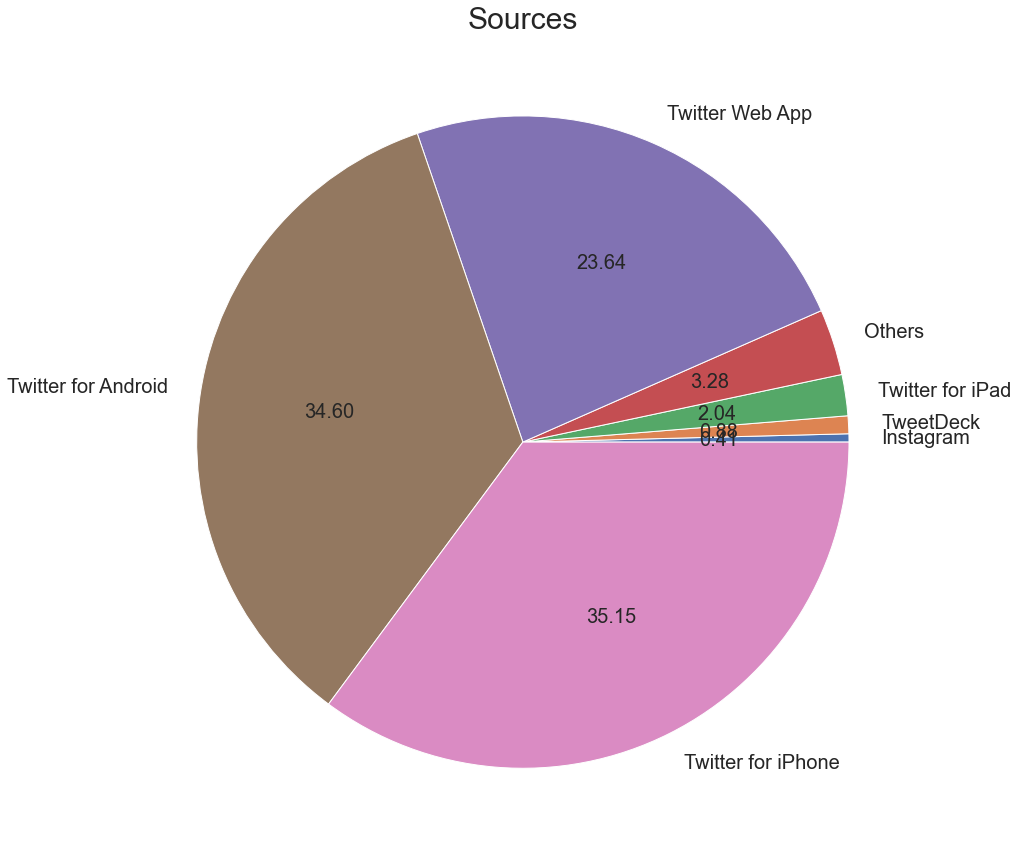

In [79]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 25
# plot chart
plt.figure(figsize=(15,15))
# realize dont need percent, pie chat calculates for you
plt.pie(sourceCount_df.source, labels=sourceCount_df.sourcename2, autopct='%.2f',textprops= {"fontsize":20})
plt.title('Sources', fontsize=30)

From the data, Android market is almost equal to iPhone. Google has performed well!

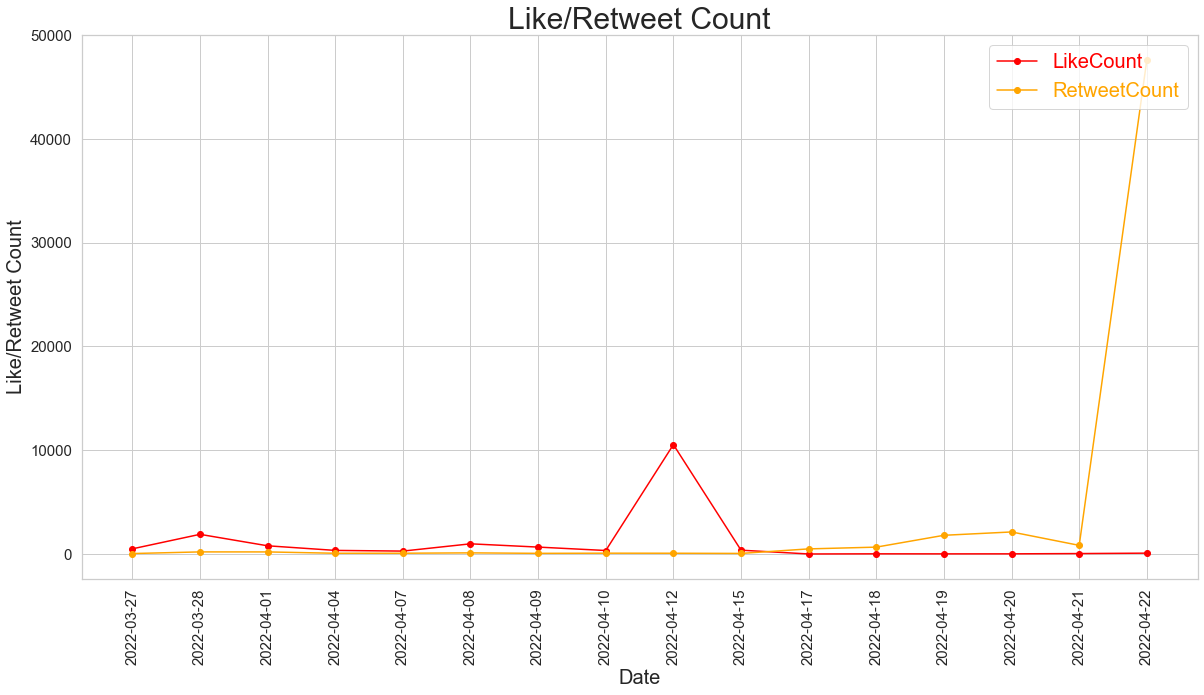

In [78]:
plt.figure(figsize=(20,10))
plt.plot(mergeGroupby_df.time, mergeGroupby_df.like_count, 'o-', label="LikeCount", color='red')
plt.plot(mergeGroupby_df.time, mergeGroupby_df.retweet_count, 'o-', label="RetweetCount", color='orange')
plt.xlabel('Date', fontsize=20)
plt.ylabel('Like/Retweet Count', fontsize = 20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15,rotation=90)
plt.title('Like/Retweet Count', fontsize=30)
plt.legend(labels=['LikeCount','RetweetCount'],labelcolor=['red','orange'],loc="upper right", prop={'size': 20})

##### Top Retweet & Like

In [80]:
# recently had huge retweet, i wanted to see what the message was
df3 = master_df2.sort_values(by='retweet_count',ascending=False)
df3.iloc[0,1]

# 1 retweet media file - https://t.co/3d3xn8MlUe

# 2 retweet
# by twitter screen name - TheRealMelissaE
# If Hollywood is going to go to such great lengths to cancel a Black man, 
# who had a moment- one single slap, out in the open,
# then it needs to go to those same lengths to cancel a white woman, 
# who repeatedly committed violence behind closed doors. #WillSmith #AmberHeard #JohnnyDepp

'RT @PeteFighter: OK……. This one wins!!\n#WillSmith #Oscars2022 #ChrisRock #StreetFighter \n\nBy bruscopa (tiktok) https://t.co/3d3xn8MlUe'

In [81]:
df4 = master_df2.sort_values(by='like_count',ascending=False)
df4.head()

# 1 like - disturbing child soilder violence
#this inhuman act by separatist group is now 'common' thing in west papua and it 
# just sad that no one from so called human rights activist condemn and even talk about this..
# https://t.co/tfQlnbm2Db

# 2 like - photo of will slapping chris
# Cette photo mérite d’être une cover d’un morceau comme NWTS  de Drake
# This photo deserves to be a cover of a track like Drake's NWTS


,user,text,time,location,source,like_count,retweet_count,quote_count,reply_count,willsmith,chrisrock,jadasmith
2931,srojeupark,this inhuman act by separatist group is now 'c...,2022-04-12,Planet Earth,Twitter Web App,4862,0,0,13,0,0,0
5079,srojeupark,this inhuman act by separatist group is now 'c...,2022-04-12,Planet Earth,Twitter Web App,4851,0,0,13,0,0,0
3419,jaidchosesadire,Cette photo mérite d’être une cover d’un morce...,2022-03-28,"Liège, Belgique",Twitter for iPhone,796,84,10,1,1,1,1
443,willsmith,Wordle 293 3/6*\n\n⬛🟨🟨⬛🟨\n🟩⬛🟨⬛🟨\n🟩🟩🟩🟩🟩\n\n100 ...,2022-04-08,"San Francisco, CA",Twitter for iPhone,346,6,4,55,0,0,0
1599,tandemperfecte,Un niño de siete años zurdo obligado a tocar e...,2022-04-07,Barcelona,Twitter for iPhone,159,38,3,12,0,0,0


#### Natural Language Processing (NLP)

##### Cleaning - Text

In [82]:
# assign new df
master_df3 = master_df2
# apply remove3 function
master_df3.text = master_df3.text.apply(remove3)
master_df3.head(10)

,user,text,time,location,source,like_count,retweet_count,quote_count,reply_count,willsmith,chrisrock,jadasmith
0,damnratez,deer infomous,2022-04-10,Sailacross It's Firebizar🙄🎶,Twitter for Android,0,0,0,0,0,1,0
1,djBESWOLF,wolfliveapp wolflive wolflovers music livemusi...,2022-04-10,"London, England",Twitter for iPhone,0,0,0,0,0,0,0
2,MsAnalytical15,new podcast janet hubert original aunt viv sta...,2022-04-10,NaN,Spreaker,1,0,0,0,1,0,0
3,okuleygodfryd,lets honest got slappedhad anyone asked knew a...,2022-04-10,"Accra, Ghana",Twitter for iPhone,0,0,0,0,0,1,0
4,BonadonnaMarco,rt smith bandito per 10 anni dagli per lo schi...,2022-04-10,Rome,Twitter for Android,0,0,0,0,1,1,0
5,glohtraveler,rt never mind jadashe helps cause continuously...,2022-04-10,"Manhattan, NYC",Twitter for iPhone,0,0,0,0,0,1,1
6,Jonti44291277,human made mistake dies one said wasnt li,2022-04-10,NaN,Twitter for iPhone,1,0,0,2,1,1,0
7,glohtraveler,rt whao chris hero example world right walk wa...,2022-04-10,"Manhattan, NYC",Twitter for iPhone,0,0,0,0,0,1,0
8,lionofgold1,rt good evil exist lord almighty says not agai,2022-04-10,NaN,Twitter for Android,0,0,0,0,0,1,0
9,TheColdIron1,say dont stand anything people say nword,2022-04-10,NaN,Twitter for Android,0,0,0,1,0,1,0


In [83]:
master_df3.shape

(6133, 12)

In [84]:
# there are text with no content, obtain their index
b = list(master_df3.text)
na = []
for a in range(len(b)):
    if b[a] == '':
        na.append(a)
len(na)

163

In [85]:
# drop rows with no text content
masterdf4 = master_df3.drop(index=na)
masterdf4.head(10)

,user,text,time,location,source,like_count,retweet_count,quote_count,reply_count,willsmith,chrisrock,jadasmith
0,damnratez,deer infomous,2022-04-10,Sailacross It's Firebizar🙄🎶,Twitter for Android,0,0,0,0,0,1,0
1,djBESWOLF,wolfliveapp wolflive wolflovers music livemusi...,2022-04-10,"London, England",Twitter for iPhone,0,0,0,0,0,0,0
2,MsAnalytical15,new podcast janet hubert original aunt viv sta...,2022-04-10,NaN,Spreaker,1,0,0,0,1,0,0
3,okuleygodfryd,lets honest got slappedhad anyone asked knew a...,2022-04-10,"Accra, Ghana",Twitter for iPhone,0,0,0,0,0,1,0
4,BonadonnaMarco,rt smith bandito per 10 anni dagli per lo schi...,2022-04-10,Rome,Twitter for Android,0,0,0,0,1,1,0
5,glohtraveler,rt never mind jadashe helps cause continuously...,2022-04-10,"Manhattan, NYC",Twitter for iPhone,0,0,0,0,0,1,1
6,Jonti44291277,human made mistake dies one said wasnt li,2022-04-10,NaN,Twitter for iPhone,1,0,0,2,1,1,0
7,glohtraveler,rt whao chris hero example world right walk wa...,2022-04-10,"Manhattan, NYC",Twitter for iPhone,0,0,0,0,0,1,0
8,lionofgold1,rt good evil exist lord almighty says not agai,2022-04-10,NaN,Twitter for Android,0,0,0,0,0,1,0
9,TheColdIron1,say dont stand anything people say nword,2022-04-10,NaN,Twitter for Android,0,0,0,1,0,1,0


In [86]:
masterdf4.shape

(5970, 12)

In [87]:
# detect language
masterdf4['lang'] = masterdf4.text.apply(lambda x :lanDetectFunc(x))

# master_df3['translateText'] = master_df3['text'].apply(translator1.translate, dest='en').apply(getattr, args=('text',))

In [88]:
masterdf4.lang.value_counts()

en    4222
es     717
fr     263
it     180
de     113
id      86
pt      72
nl      64
no      50
da      17
sv      16
ms      15
ca      13
pl      13
tr      13
tl      12
mt      10
sw       9
et       8
af       8
cy       7
eu       7
eo       6
rw       6
ro       5
hr       5
sl       4
br       4
nn       2
an       2
oc       2
gl       2
fi       2
la       2
ga       2
lb       2
xh       2
lt       1
lv       1
mg       1
bs       1
sq       1
az       1
hu       1
Name: lang, dtype: int64

In [89]:
# reset index again
masterdf4.reset_index(drop=True)

# backup to csv
# masterdf4.to_csv('datadf/cleanedDf.csv')

,user,text,time,location,source,like_count,retweet_count,quote_count,reply_count,willsmith,chrisrock,jadasmith,lang
0,damnratez,deer infomous,2022-04-10,Sailacross It's Firebizar🙄🎶,Twitter for Android,0,0,0,0,0,1,0,nl
1,djBESWOLF,wolfliveapp wolflive wolflovers music livemusi...,2022-04-10,"London, England",Twitter for iPhone,0,0,0,0,0,0,0,en
2,MsAnalytical15,new podcast janet hubert original aunt viv sta...,2022-04-10,NaN,Spreaker,1,0,0,0,1,0,0,en
3,okuleygodfryd,lets honest got slappedhad anyone asked knew a...,2022-04-10,"Accra, Ghana",Twitter for iPhone,0,0,0,0,0,1,0,en
4,BonadonnaMarco,rt smith bandito per 10 anni dagli per lo schi...,2022-04-10,Rome,Twitter for Android,0,0,0,0,1,1,0,it
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5965,SpeakMeow6,rt confirmado cancela sus planes sobre una sec...,2022-04-22,NaN,Twitter for iPhone,0,39,NaN,NaN,0,0,0,es
5966,VanElyo,rt confirmado cancela sus planes sobre una sec...,2022-04-22,La Laguna,Twitter for Android,0,39,NaN,NaN,0,0,0,es
5967,Taurus89514630,rt top 10 news week smith gill respond trolls ...,2022-04-22,NaN,Twitter for Android,0,352,NaN,NaN,1,0,0,en
5968,LSwagata,rt top 10 news week smith gill respond trolls ...,2022-04-22,NaN,Twitter for Android,0,352,NaN,NaN,1,0,0,en


In [90]:
masterdf4.shape

(5970, 13)

In [91]:
# make new df, select only en
masterdf5 = masterdf4[masterdf4.lang =='en']

# none eng words
masterdf5['text2'] = masterdf5.text.apply(engOnly)

# assign sentimentscore
masterdf5['blobscore'] = masterdf5.text2.apply(lambda x : TextBlob(x).sentiment.polarity)

masterdf5.shape

/var/folders/fy/_jcf8bdn3hbccf_yk638qvkw0000gn/T/ipykernel_852/1953886280.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  masterdf5['text2'] = masterdf5.text.apply(engOnly)
/var/folders/fy/_jcf8bdn3hbccf_yk638qvkw0000gn/T/ipykernel_852/1953886280.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  masterdf5['blobscore'] = masterdf5.text2.apply(lambda x : TextBlob(x).sentiment.polarity)


(4222, 15)

In [92]:
# add sent using text 2
masterdf5['blobsent'] = masterdf5.text2.apply(blobSent)
masterdf5.shape

/var/folders/fy/_jcf8bdn3hbccf_yk638qvkw0000gn/T/ipykernel_852/327221747.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  masterdf5['blobsent'] = masterdf5.text2.apply(blobSent)


(4222, 16)

In [93]:
# obtain unique tweets
masterdf6 = masterdf5.drop_duplicates(subset='text2',keep='last')
masterdf6.shape
# list # obtain word pool of unique tweets
wordpool = list(masterdf6.text2)
# string - joiin each sentence
wordpool3 = ' '.join(wordpool)
# list of words - split into words
wordpool2 = wordpool3.split(' ')
len(wordpool2)

15822

In [94]:
# count
wordcountset = FreqDist(wordpool2)
wordcountset.most_common(20)

[('smith', 1245),
 ('rock', 519),
 ('not', 248),
 ('slap', 145),
 ('like', 133),
 ('joke', 123),
 ('people', 118),
 ('one', 111),
 ('dont', 110),
 ('would', 90),
 ('get', 87),
 ('think', 83),
 ('academy', 81),
 ('know', 79),
 ('see', 78),
 ('man', 73),
 ('love', 72),
 ('slapping', 71),
 ('good', 64),
 ('wife', 64)]

##### Visualization - Text

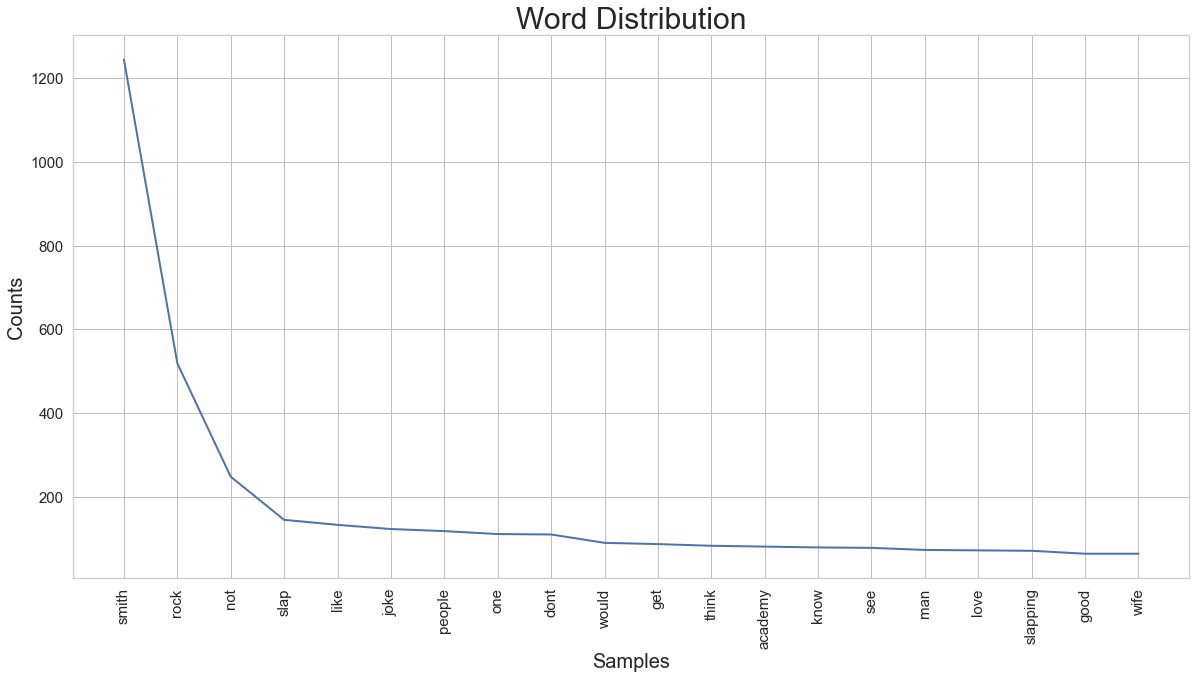

<AxesSubplot:title={'center':'Word Distribution'}, xlabel='Samples', ylabel='Counts'>

In [95]:
plt.figure(figsize=(20,10))
# Annotation
plt.xlabel('Words', fontsize=20)
plt.ylabel('Counts', fontsize = 20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15,rotation=90)
plt.title('Word Distribution', fontsize=30)
wordcountset.plot(20)

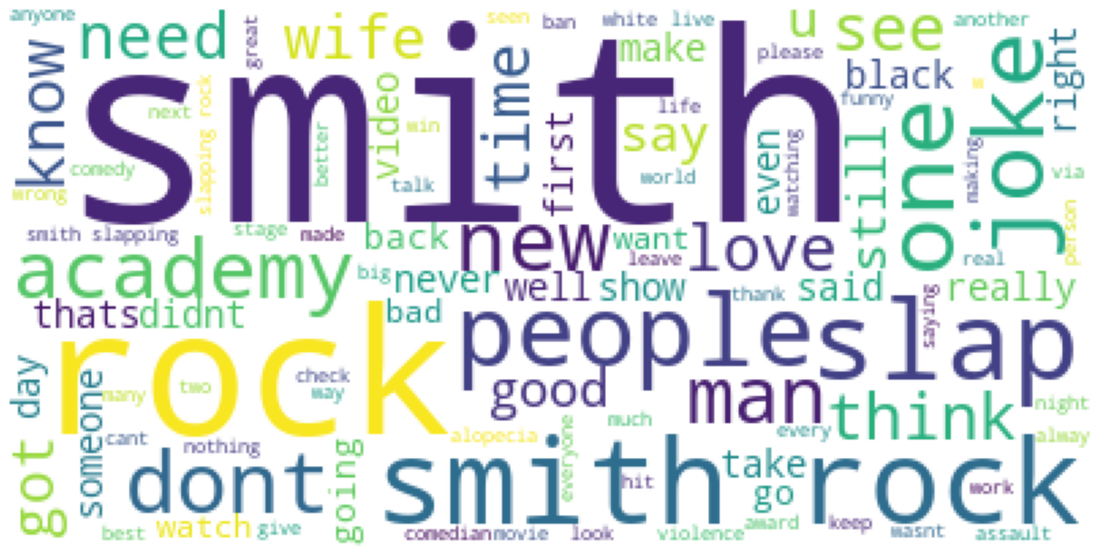

In [103]:
wc = WordCloud(background_color='white', max_words=100, stopwords = STOPWORDS)

# Generate and plot wordcloud
plt.figure(figsize=(20,10))
plt.imshow(wc.generate(wordpool3))
plt.axis('off')
plt.show()

In [97]:
# we use 5 because we dont want unique tweets, every retweet should add weight on sentiment
willsentdf = masterdf5[masterdf5.willsmith == 1]
jadasentdf = masterdf5[masterdf5.jadasmith == 1]
chrissentdf = masterdf5[masterdf5.chrisrock == 1]

Text(0.5, 1.0, 'Will Smith Sentiment by Date')

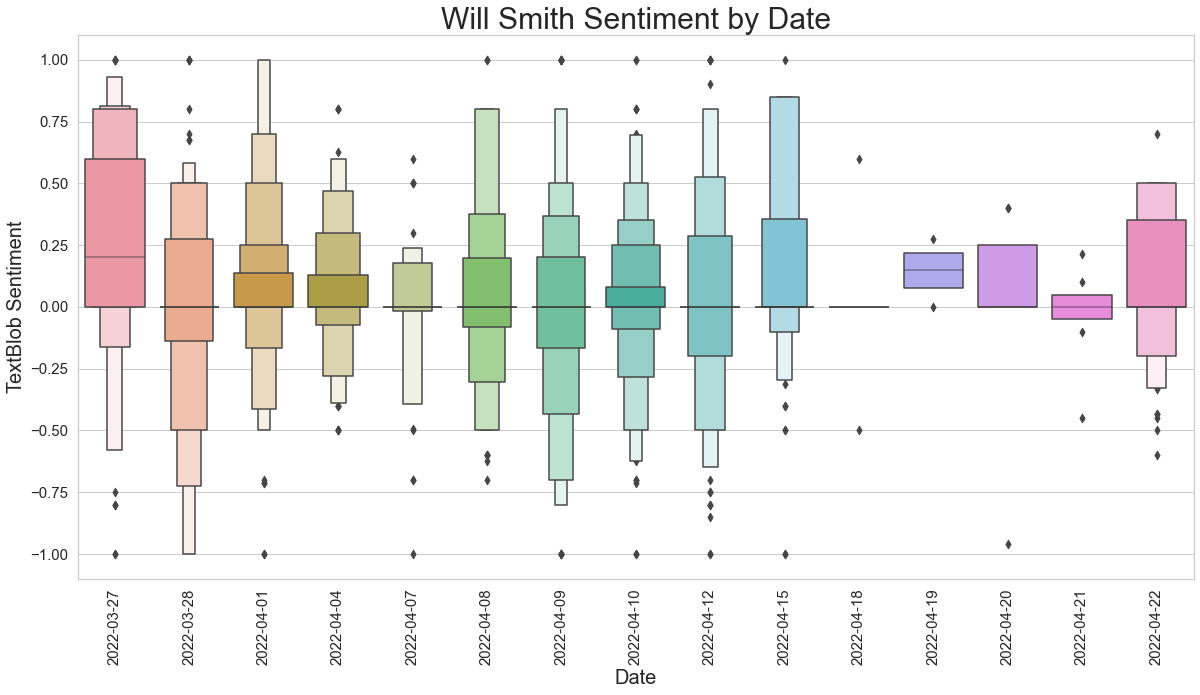

In [110]:
plt.figure(figsize=(20,10))
sns.boxenplot(y="blobscore", x="time", scale='linear',data=willsentdf.sort_values(by='time'))
# Annotation
plt.xlabel('Date', fontsize=20)
plt.ylabel('TextBlob Sentiment', fontsize = 20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15,rotation=90)
plt.title('Will Smith Sentiment by Date', fontsize=30)

Text(0.5, 1.0, 'Chris Rock Sentiment by Date')

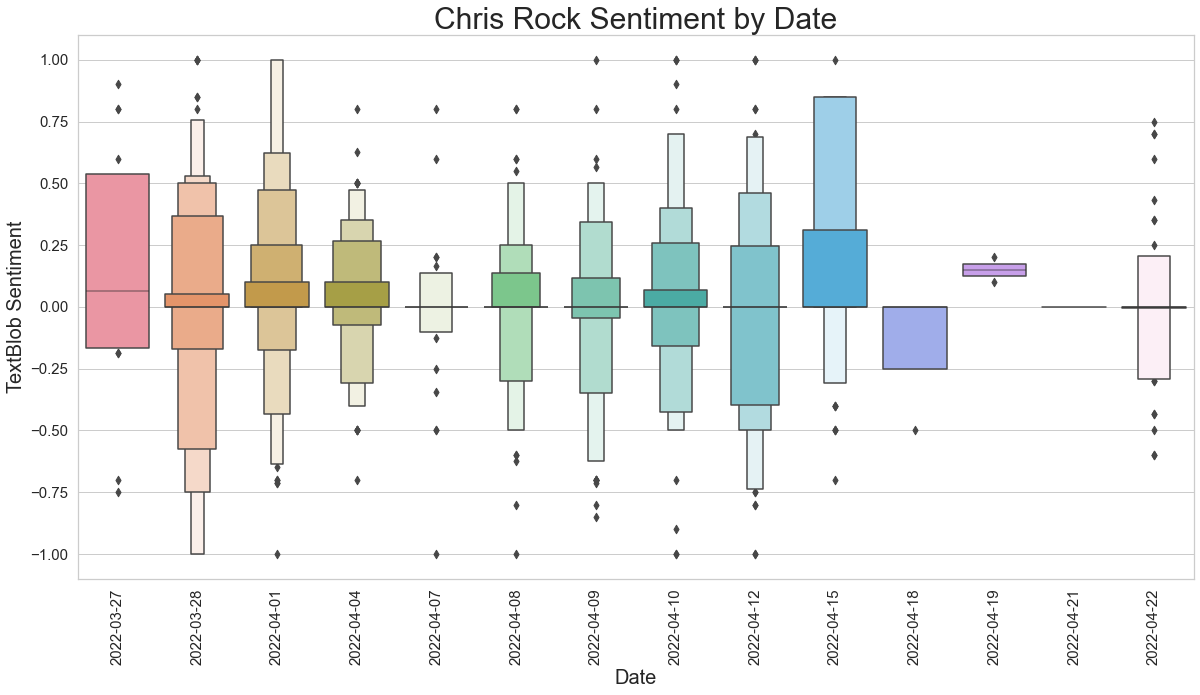

In [111]:
plt.figure(figsize=(20,10))
sns.boxenplot(y="blobscore", x="time", scale='linear',data=chrissentdf.sort_values(by='time'))
# Annotation
plt.xlabel('Date', fontsize=20)
plt.ylabel('TextBlob Sentiment', fontsize = 20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15,rotation=90)
plt.title('Chris Rock Sentiment by Date', fontsize=30)

Text(0.5, 1.0, 'Jada Smith Sentiment by Date')

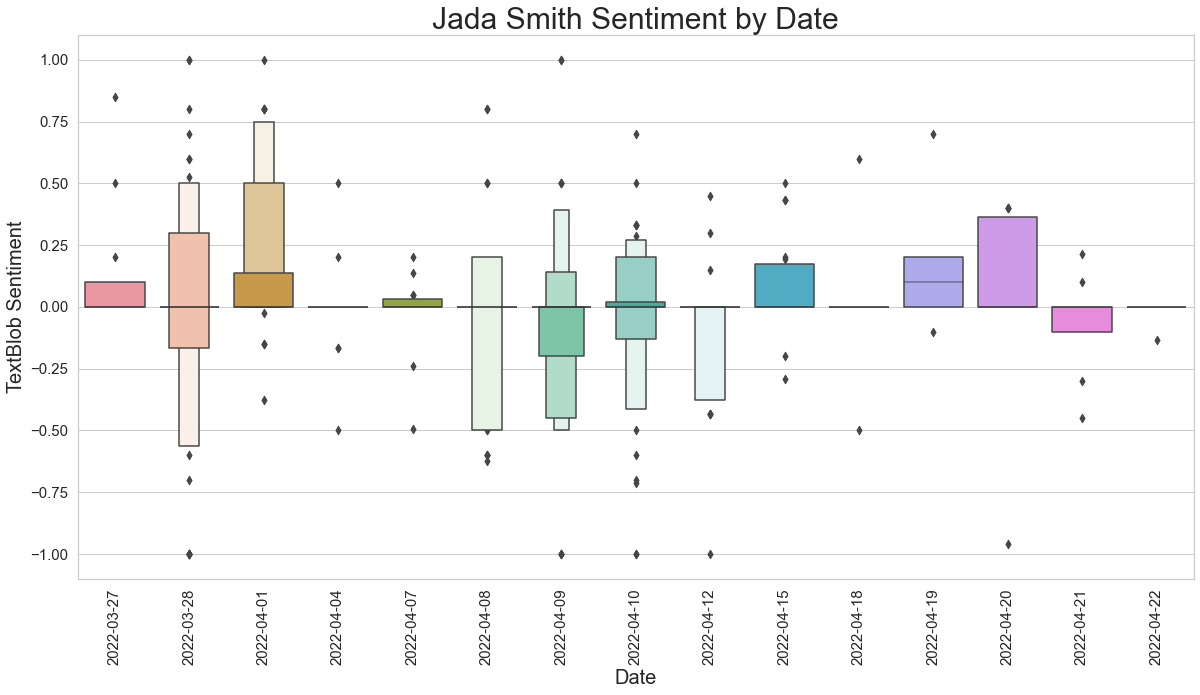

In [112]:
plt.figure(figsize=(20,10))
sns.boxenplot(y="blobscore", x="time", scale='linear',data=jadasentdf.sort_values(by='time'))
# Annotation
plt.xlabel('Date', fontsize=20)
plt.ylabel('TextBlob Sentiment', fontsize = 20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15,rotation=90)
plt.title('Jada Smith Sentiment by Date', fontsize=30)

Seems like tweets may be sympathetic towards Jada at the beginning. When Will got banned, tweets are negative towards her.

##### Named Entity Recognition

In [151]:
nlp = spacy.load('en_core_web_lg')

# list # obtain word pool of unique tweets
nerpool = list(masterdf6.text)
# string - joiin each sentence
nerpool2 = ';'.join(nerpool)

doc_q = nlp(nerpool2)

displacy.render(doc_q, style='ent', jupyter=True)

#### Deep Learning

In [116]:
masterdf6 = masterdf5.reset_index(drop=True)
masterdf6.head(1)

,user,text,time,location,source,like_count,retweet_count,quote_count,reply_count,willsmith,chrisrock,jadasmith,lang,text2,blobscore,blobsent
0,djBESWOLF,wolfliveapp wolflive wolflovers music livemusi...,2022-04-10,"London, England",Twitter for iPhone,0,0,0,0,0,0,0,en,music,0.0,Neutral


In [117]:
masterdf6['text_noname'] = masterdf6.text2.apply(lambda x : removeName(x.split()))
masterdf6.head(1)

,user,text,time,location,source,like_count,retweet_count,quote_count,reply_count,willsmith,chrisrock,jadasmith,lang,text2,blobscore,blobsent,text_noname
0,djBESWOLF,wolfliveapp wolflive wolflovers music livemusi...,2022-04-10,"London, England",Twitter for iPhone,0,0,0,0,0,0,0,en,music,0.0,Neutral,[music]


In [118]:
# load model
model = load_model('data3/LSTM.h5') # max length 15

# load tokenizer
with open('data3/token_mdl1.pickle', 'rb') as handle:
    token = pickle.load(handle)

In [119]:
masterdf6['predict_sent'] = masterdf6.text_noname.apply(lambda x: predictFunc(x))
masterdf6 = masterdf6[masterdf6.predict_sent!='NoWork']

In [120]:
masterdf6['predict_score'] = masterdf6['predict_sent'].map({'Negative': -1, 'Neutral': 0, 'Positive':1})

In [121]:
# we use 5 because we dont want unique tweets, every retweet should add weight on sentiment
masterdf7 = masterdf6[masterdf6.predict_sent!='Neutral']
willsentdf2 = masterdf7[masterdf6.willsmith == 1]
jadasentdf2 = masterdf7[masterdf6.jadasmith == 1]
chrissentdf2 = masterdf7[masterdf6.chrisrock == 1]

/var/folders/fy/_jcf8bdn3hbccf_yk638qvkw0000gn/T/ipykernel_852/3833716636.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  willsentdf2 = masterdf7[masterdf6.willsmith == 1]
/var/folders/fy/_jcf8bdn3hbccf_yk638qvkw0000gn/T/ipykernel_852/3833716636.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  jadasentdf2 = masterdf7[masterdf6.jadasmith == 1]
/var/folders/fy/_jcf8bdn3hbccf_yk638qvkw0000gn/T/ipykernel_852/3833716636.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  chrissentdf2 = masterdf7[masterdf6.chrisrock == 1]


Text(0.5, 1.0, 'Will Smith Sentiment by Date')

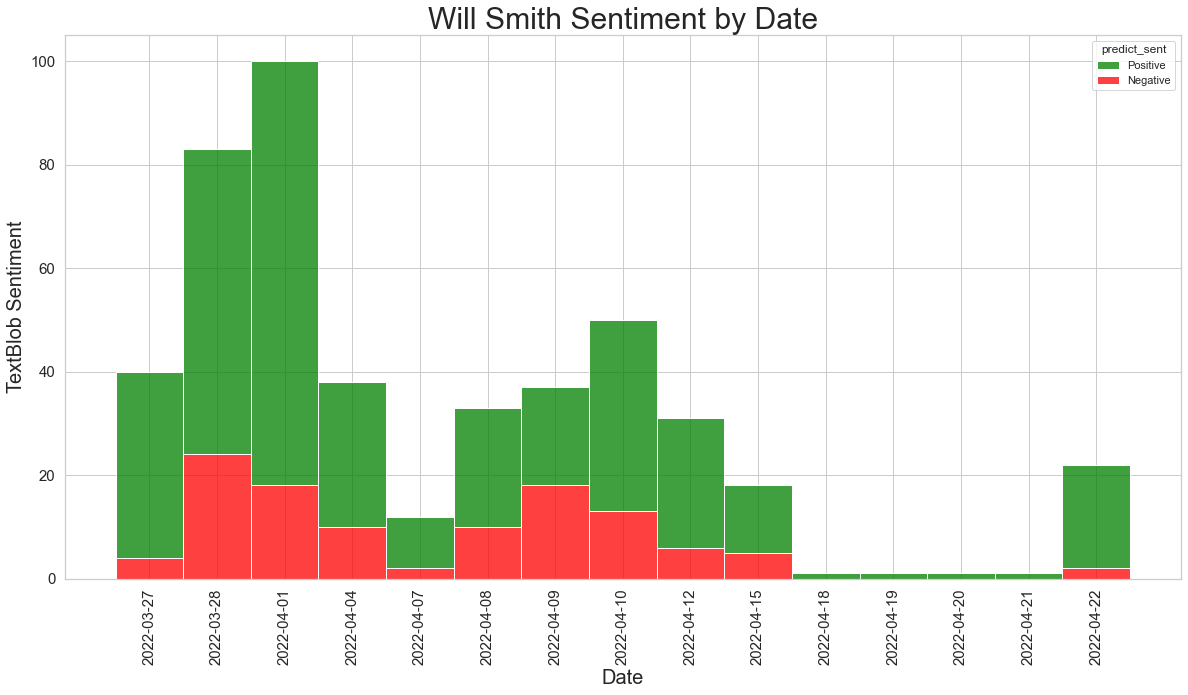

In [122]:
# Histplot stacked by type
plt.figure(figsize=(20,10))
sns.histplot(data=willsentdf2.sort_values(by='time'),x='time',hue='predict_sent',multiple='stack',edgecolor='white',hue_order=['Positive','Negative'],palette=['green','red'])
# Annotation
plt.xlabel('Date', fontsize=20)
plt.ylabel('TextBlob Sentiment', fontsize = 20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15,rotation=90)
plt.title('Will Smith Sentiment by Date', fontsize=30)

Text(0.5, 1.0, 'Chris Rock Sentiment by Date')

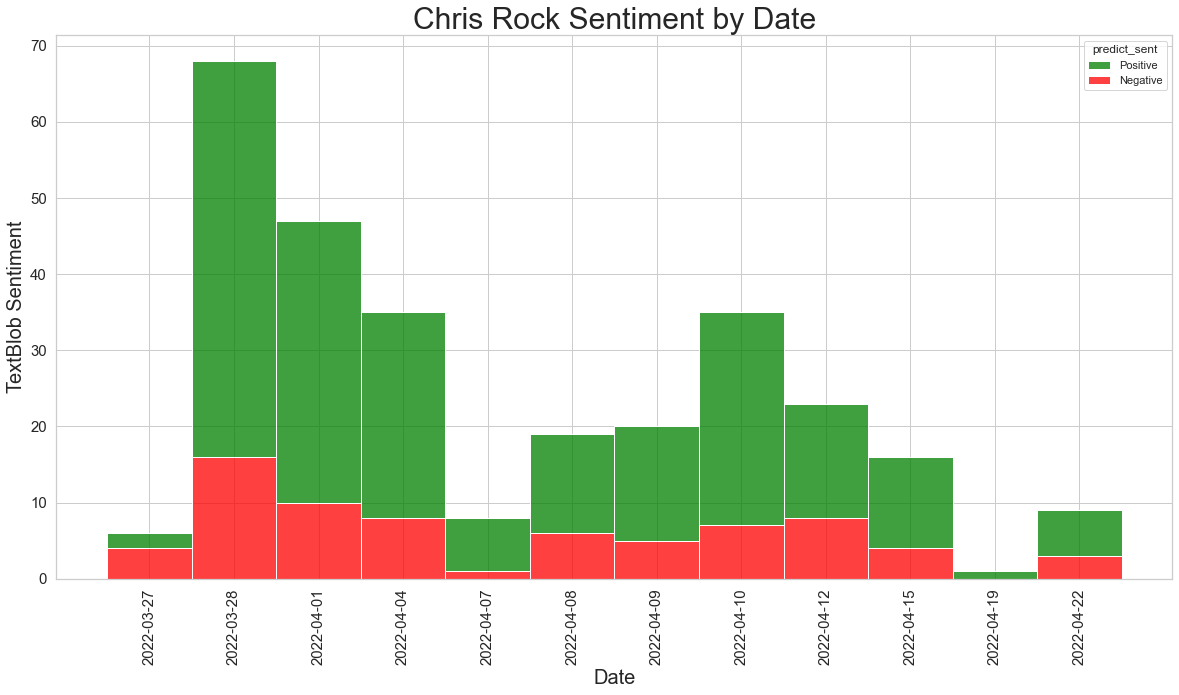

In [123]:
plt.figure(figsize=(20,10))
sns.histplot(data=chrissentdf2.sort_values(by='time'),x='time',hue='predict_sent',multiple='stack',edgecolor='white',hue_order=['Positive','Negative'],palette=['green','red'])
# Annotation
plt.xlabel('Date', fontsize=20)
plt.ylabel('TextBlob Sentiment', fontsize = 20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15,rotation=90)
plt.title('Chris Rock Sentiment by Date', fontsize=30)

Text(0.5, 1.0, 'Jada Smith Sentiment by Date')

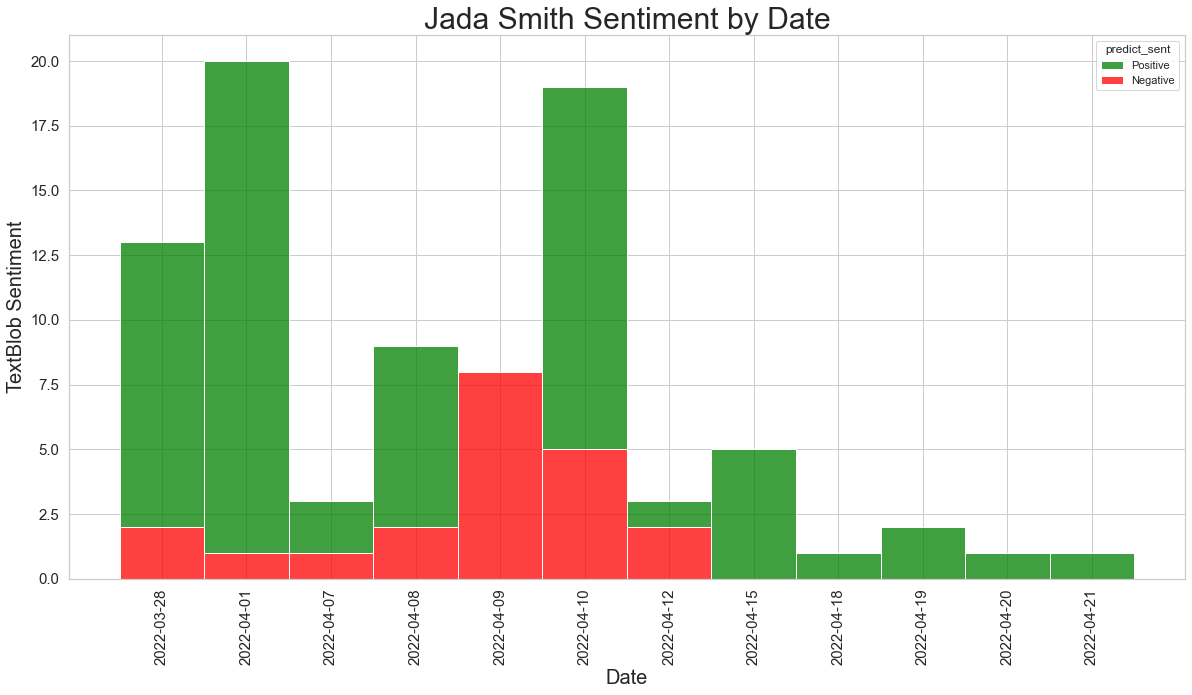

In [124]:
plt.figure(figsize=(20,10))
sns.histplot(data=jadasentdf2.sort_values(by='time'),x='time',hue='predict_sent',multiple='stack',edgecolor='white',hue_order=['Positive','Negative'],palette=['green','red'])
# Annotation
plt.xlabel('Date', fontsize=20)
plt.ylabel('TextBlob Sentiment', fontsize = 20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15,rotation=90)
plt.title('Jada Smith Sentiment by Date', fontsize=30)